# Graph search algorithms
This notebook contains my go to versions of depth-first search, breadth-first search, Dijkstra's algorithm and A* search.
It illustrates their similarity in implementation and difference in effectiveness when applied to the problem of finding a path between two nodes.

## Sample graph

In [1]:
from math import sqrt

POSITIONS = dict(enumerate([
    (0, 0), (10, 12), (24, 20), (30, 36), (50, 50), (10, 45), (30, 10), (47, 25), (20, 35), (35, 5)
]))
EDGES = [
    (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (5, 4), (0, 6), (1, 6),
    (2, 6), (3, 6), (6, 7), (7, 4), (5, 8), (8, 3), (9, 6)
]
distance = lambda u_x, u_y, v_x, v_y: sqrt((u_x - v_x) ** 2 + (u_y - v_y) ** 2)
GRAPH = {
    u: [
        (v, distance(*u_pos, *v_pos))
        for v, v_pos in POSITIONS.items() if (u, v) in EDGES or (v, u) in EDGES
    ] for u, u_pos in POSITIONS.items()
}

START = 0
FINISH = 4

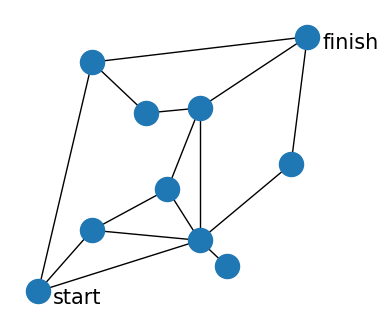

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4.2, 4))
PLOT_KWARGS = {
    'G': nx.Graph({u: [v for v, d in neighbors] for u, neighbors in GRAPH.items()}),
    'pos': POSITIONS
}
nx.draw(**PLOT_KWARGS, node_color='#1f77b4', ax=ax)
for name, u in [('start', START), ('finish', FINISH)]:
    x, y = POSITIONS[u]
    ax.text(x + 2.8, y - 2.5, name, fontsize=15)

## Implementations
All search functions assume the input graph is a dictionary of `node: [(neighbor1, ...), (neighbor2, ...), ...]`.
Dijkstra and A* assume a dictionary of `node: [(neighbor1, edge1cost), (neighbor2, edge2cost), ...]`.
The output of all functions is a dictionary of `node: (encounter_number, parent, ...)`,
where `encounter_number` indicates when the node was explored and `parent` from which neighbor it was discovered.
The last-mentioned information is required to reconstruct the path found between start and finish.

### [Depth-first search](https://en.wikipedia.org/wiki/Depth-first_search)

In [3]:
def depth_first_search(graph, start):
    frontier = [(start, None)]
    explored = {}
    while frontier:
        u, parent = frontier.pop()
        if u not in explored:
            encounter_number = len(explored)
            explored[u] = (encounter_number, parent)
            for v, *_ in graph[u]:
                frontier.append((v, u))
    return explored

### [Breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search)

In [4]:
from collections import deque  # provides efficient left pop

def breadth_first_search(graph, start):
    frontier = deque([(start, None)])
    explored = {}
    while frontier:
        u, parent = frontier.popleft()
        if u not in explored:
            encounter_number = len(explored)
            explored[u] = (encounter_number, parent)
            for v, *_ in graph[u]:
                frontier.append((v, u))
    return explored

### [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)

In [5]:
from heapq import heappop, heappush  # provide efficient min pop

def dijkstra_search(graph, start):
    frontier = [(0, (start, None))]
    explored = {}
    while frontier:
        distance, (u, parent) = heappop(frontier)
        if u not in explored or distance < explored[u][2]:
            encounter_number = explored[u][0] if u in explored else len(explored)
            explored[u] = (encounter_number, parent, distance)
            for v, edge_length in graph[u]:
                heappush(frontier, (distance + edge_length, (v, u)))
    return explored

### [A* search](https://en.wikipedia.org/wiki/A*_search_algorithm)

In [6]:
from heapq import heappop, heappush  # provide efficient min pop

bird_distance_to_finish = lambda u: distance(*POSITIONS[u], *POSITIONS[FINISH])

def a_star_search(graph, start, heuristic=bird_distance_to_finish):
    frontier = [(heuristic(start), 0, (start, None))]
    explored = {}
    while frontier:
        score, distance, (u, parent) = heappop(frontier)
        if u not in explored or distance < explored[u][2]:
            encounter_number = explored[u][0] if u in explored else len(explored)
            explored[u] = (encounter_number, parent, distance)
            for v, edge_length in graph[u]:
                v_distance = distance + edge_length
                heappush(frontier, (v_distance + heuristic(v), v_distance, (v, u)))
    return explored

## Results

In [7]:
algorithms = {
    'depth-first': depth_first_search,
    'breadth-first': breadth_first_search,
    'Dijkstra': dijkstra_search,
    'A*': a_star_search
}
results = {name: search(GRAPH, START) for name, search in algorithms.items()}

In the following plots, node labels indicate order of exploration and orange color that a node is part of the discovered path between start and finish.
Comparison of the depth-first and breadth-first node exploration orders illustrates how the latter produces a search tree with more branches than the former,
which covers all except the node labelled 2 with the same path (0-1-3-4-5-6-7-8-9).

Comparison of the discovered paths illustrates that
- depth-first finds *a* path between start and finish
- breadth-first finds the path that is "shortest" in terms of number of nodes visited
- Dijkstra finds the shortest path in terms of actual distance travelled
- A* also finds the shortest path, and does so faster (at step 4) than Dijkstra (which finds it at step 9)

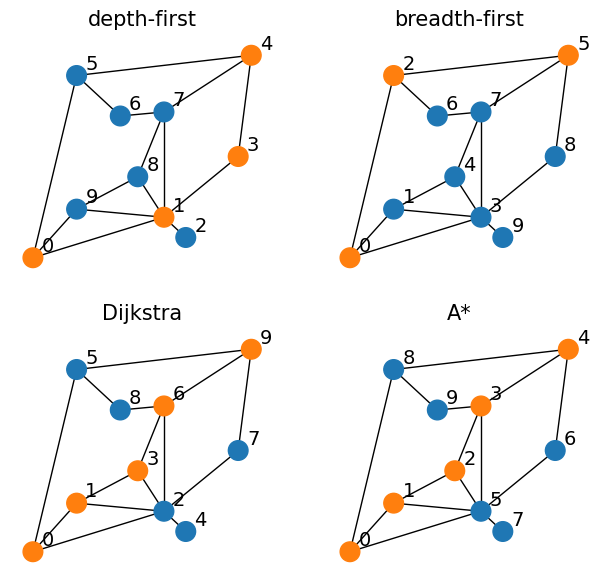

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 7))
for (name, result), ax in zip(results.items(), axs.ravel()):
    path = [FINISH]
    while path[-1] != START:
        path.append(result[path[-1]][1])

    node_colors = ['#ff7f0e' if u in path else '#1f77b4' for u in range(len(result))]
    nx.draw(**PLOT_KWARGS, node_color=node_colors, node_size=200, ax=ax)
    ax.set_title(name, fontsize=15)
    for u, (encounter_number, *_) in result.items():
        x, y = POSITIONS[u]
        ax.text(x + 2, y + 1.5, encounter_number, fontsize=14)

## Convert this notebook to Markdown

In [ ]:
from ipylab import JupyterFrontEnd
JupyterFrontEnd().commands.execute('docmanager:save')

In [ ]:
!jupyter nbconvert notebook.ipynb --to markdown --output README.md \
    --TagRemovePreprocessor.remove_input_tags='{"remove_input"}' \
    --TagRemovePreprocessor.remove_cell_tags='{"remove"}'